<a href="https://colab.research.google.com/github/morfant/TF_study/blob/master/TF_week_01_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q seaborn
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.2.0-rc2


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


In [0]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
print(dataset_path)

/root/.keras/datasets/auto-mpg.data


In [0]:
columns_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]
raw_dataset = pd.read_csv(dataset_path, names=columns_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
# dataset.head()
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [0]:
dataset.isna().sum()
dataset = dataset.dropna()

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'EU', 3: 'Japan'})
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,EU
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [0]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,EU,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [0]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

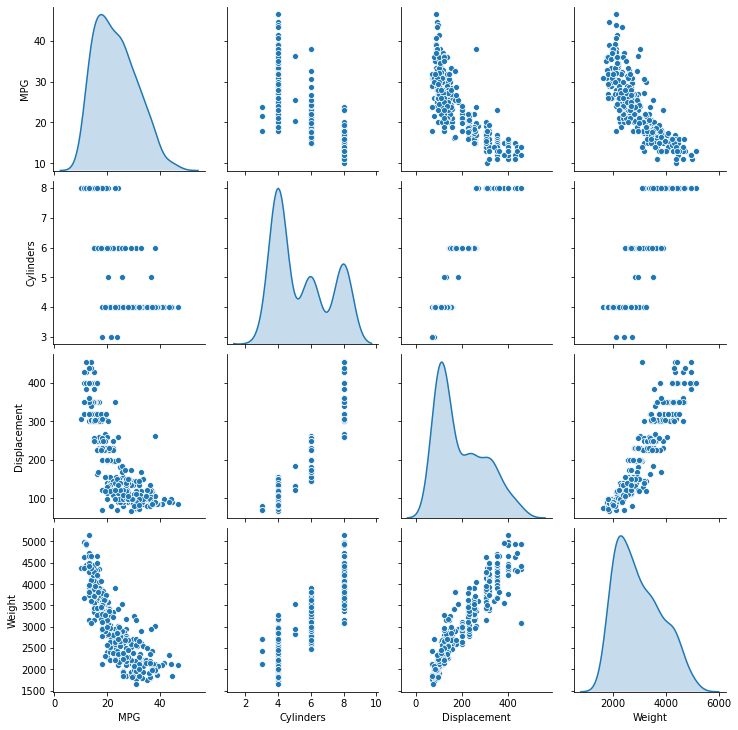

In [0]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
EU,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [0]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop('MPG')
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

# print(train_dataset)
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss="mse",
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [0]:
example_batch = normed_test_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-1.7327437 ],
       [-1.5391629 ],
       [-1.0792588 ],
       [-0.05665797],
       [-0.5512965 ],
       [-1.426356  ],
       [-1.0383323 ],
       [-1.37496   ],
       [-0.2978549 ],
       [-0.0904077 ]], dtype=float32)

In [101]:
EPOCHS = 1000

print(train_labels)

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()]
)

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

Epoch: 0, loss:1.4505,  mae:0.6703,  mse:1.4708,  val_loss:9.1282,  val_mae:2.2351,  val_mse:9.0898,  
....................................................................................................
Epoch: 100, loss:1.1223,  mae:0.5937,  mse:1.1232,  val_loss:9.5441,  val_mae:2.2812,  val_mse:9.5098,  
....................................................................................................
Epoch: 200, loss:1.2270,  mae:0.6366,  mse:1.2334,  val_loss:9.6926,  val_mae:2.3474,  val_mse:9.6481,  
....................................................................................................
Epoch: 300, loss:1.1108,  mae:0.5931,  mse:1.0796,  val_loss:11.3021,  val_mae:2.6349,  val_mse:11.2464,  
....................................................................................................
Epoc

In [106]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,1.450485,0.670319,1.470756,9.128201,2.235064,9.089819,0
1,1.150958,0.612548,1.158889,9.388218,2.283459,9.349793,1
2,1.355612,0.726833,1.357515,9.407270,2.326993,9.358377,2
3,1.403401,0.705748,1.382529,9.556530,2.344537,9.510370,3
4,1.412389,0.685499,1.361757,9.380634,2.256208,9.346611,4


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

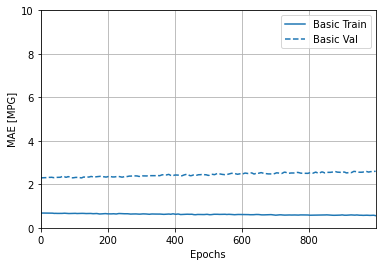

In [104]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

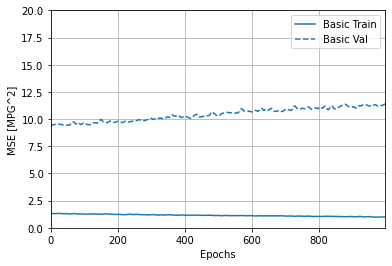

In [105]:
plotter.plot({'Basic': history}, metric = 'mse')
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [109]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels,
                          epochs=EPOCHS, validation_split=0.2, verbose=0,
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:549.8515,  mae:22.1272,  mse:551.5092,  val_loss:538.6958,  val_mae:21.7847,  val_mse:539.0077,  
.......................................................................

Text(0, 0.5, 'MAE [MPG]')

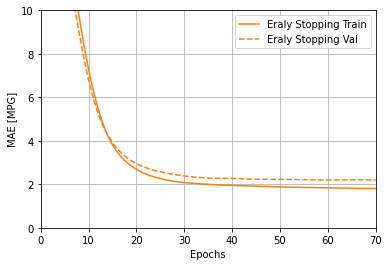

In [120]:
plotter.plot({'Eraly Stopping': early_history}, metric='mae')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [121]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.3047 - mae: 1.9317 - mse: 5.9438
Testing set Mean Abs Error:  1.93 MPG


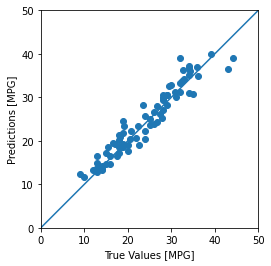

In [122]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

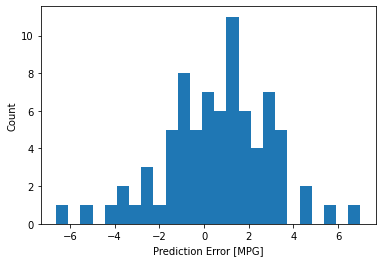

In [123]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel("Count")